---
title: "DecisionTrees"
format: html
---

# Methods

Decision trees are a supervised machine learning method which can be used for both classification and regression. The overall goal of a decision tree is to predict the value of a target variable by learning rules based on the features. The process begins at the root node, which represents the entire dataset you are working with. The root node has no parent node, in that there are no nodes before it; it is not the child of any other node. Then the root node is split into two or more sub nodes based on a set of conditional rules of a feature. For example, a rule could be, in my case, the percent change in the number of highschool graduates is greater than 5%. If this a true for the given datapoint, then it will head towards a trajectory in the tree, and if it is not true it will go on a different trajectory. Each non-terminal node, or nodes that have children, is a decision node where a split happens. Decision trees use multiple algorithms to strategically split the tree on certain features and conditions, using various attribute selection measures as well to see which features are most important. The leaf node, or terminal node, is the end of the tree where a prediction is made, which could be either a number or label depending on if it is a classification or regression tree. Decision trees are useful for their interprebility and acccuracy, but can be prone to overfitting. Pruning helps remedy this by remvoing decsision nodes in the tree.

Random forests are an extension of decision trees that can also aid in avoiding overfitting while still maintaining accuracy and also can provide us insight on feature importance. The process for creating a random forest goes as follows. You create a bootstrapped dataset, where bootstrapping is sampling your existing dataset with replacement.Then, you create a decision tree from the bootstrapped dataset, but with a random subset of variables at each step.Then you repeat this many times constructing a "forest" of decision trees. Then, when you input a datapoint in your model, it is fed into each tree and each tree makes a prediction, then the trees 'vote' for classification, or average the predictions for regression, to make a final prediction. You can see the total amount that the RSS decreased due to splits over a given feature and average over all the trees to see which variables contributed most to decreasing error.

Boosting works similarly to random forests, but the trees are made sequentially, in that each tree is grown based on information from previous trees. Specifically I will discuss the Adaboost model. Instead of constructing whole decision trees, the trees are usually just a node and two leaves, only using one variable to make a decision. We call it a stump. Individual stumps are weak predictors, but errors that the first stump makes influence how the second stump is made. By attaching weights to each sample from the dataset that you are bootstrapping, the next stump that will be made will take the errors of the current stump into account. By increasing sample weights for incorrectly classified samples, and decreasing sample weights for correctly classfied samples, points that did poorily will be heavily sampled for the creation of the next stump. Each stump also has a different "Amount of say" for the final classification, depending on their performance.


# Class Distribution

In [205]:
import pandas as pd
import numpy as np
import random
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV

Here I will recycle code from my Naive Bayes analysis to transform my continuous target variable into a label.

In [81]:
record=pd.read_csv('data/RecordData.csv')
record=record.drop('DP05_0037E',axis=1)
mean=record['Typical Home Value'].mean()
recordClass=record.copy()
recordClass['Typical Home Value']=recordClass['Typical Home Value'].apply(lambda x:1 if x>mean else 0)
recordClass=recordClass.drop(['Year','RegionName'],axis=1)
recordClass.head()

,DP02_0001E,DP02_0002E,DP02_0003E,DP02_0007E,DP02_0011E,DP02_0037E,DP02_0060E,DP02_0061E,DP02_0062E,DP02_0063E,...,DP04_0047E,DP04_0134E,DP05_0001E,DP05_0004E,DP05_0018E,DP05_0038E,DP05_0039E,DP05_0044E,DP05_0073E,Typical Home Value
0,0.007341,0.009226,-0.008186,0.090413,0.007228,0.004783,0.022710,-0.002918,0.018174,0.033732,...,0.007581,0.050667,0.002692,0.003198,0.010283,-0.000327,-0.123824,-0.027097,0.217687,0
1,0.022851,-0.265678,-0.360479,-0.317095,-0.802204,1.302990,-0.588360,-0.705200,0.439418,1.429793,...,-0.000968,0.024112,0.003133,-0.006376,0.002545,0.009572,0.054480,0.015884,-0.178100,0
2,0.036880,0.013836,0.056032,-0.010988,0.081890,-0.050374,-0.025077,-0.044056,0.038532,0.007408,...,-0.004602,0.066914,0.027878,0.008556,0.010152,-0.010947,0.067268,0.040587,-0.005625,1
3,0.024848,0.041137,0.053954,-0.058821,0.009307,0.106362,-0.070979,-0.062720,-0.020504,0.014854,...,0.017788,0.060395,0.006829,-0.001060,-0.005025,-0.002353,-0.017318,0.146484,10.243876,0
4,0.015195,0.000753,-0.043082,-0.078405,0.043289,0.942898,-0.208181,0.031255,0.017837,-0.065209,...,-0.043262,-0.019983,-0.003186,-0.009174,0.011594,0.139775,0.012942,-0.060828,0.054155,0


Here will be my data for my regression model.

In [82]:
record=record.drop(['Year','RegionName'],axis=1)
record.head()

,DP02_0001E,DP02_0002E,DP02_0003E,DP02_0007E,DP02_0011E,DP02_0037E,DP02_0060E,DP02_0061E,DP02_0062E,DP02_0063E,...,DP04_0047E,DP04_0134E,DP05_0001E,DP05_0004E,DP05_0018E,DP05_0038E,DP05_0039E,DP05_0044E,DP05_0073E,Typical Home Value
0,0.007341,0.009226,-0.008186,0.090413,0.007228,0.004783,0.022710,-0.002918,0.018174,0.033732,...,0.007581,0.050667,0.002692,0.003198,0.010283,-0.000327,-0.123824,-0.027097,0.217687,0.038688
1,0.022851,-0.265678,-0.360479,-0.317095,-0.802204,1.302990,-0.588360,-0.705200,0.439418,1.429793,...,-0.000968,0.024112,0.003133,-0.006376,0.002545,0.009572,0.054480,0.015884,-0.178100,0.070360
2,0.036880,0.013836,0.056032,-0.010988,0.081890,-0.050374,-0.025077,-0.044056,0.038532,0.007408,...,-0.004602,0.066914,0.027878,0.008556,0.010152,-0.010947,0.067268,0.040587,-0.005625,0.263465
3,0.024848,0.041137,0.053954,-0.058821,0.009307,0.106362,-0.070979,-0.062720,-0.020504,0.014854,...,0.017788,0.060395,0.006829,-0.001060,-0.005025,-0.002353,-0.017318,0.146484,10.243876,0.076587
4,0.015195,0.000753,-0.043082,-0.078405,0.043289,0.942898,-0.208181,0.031255,0.017837,-0.065209,...,-0.043262,-0.019983,-0.003186,-0.009174,0.011594,0.139775,0.012942,-0.060828,0.054155,0.005789


In [22]:
recordClass['Typical Home Value'].value_counts()

Typical Home Value
0    145
1     59
Name: count, dtype: int64

The classes are fairly uneven and there is overall not a lot of data, so the algorithm might struggle to learn patterns, especially with the minority class. The model might be biased towards the majority class as well. We also must not only rely on accuracy to understand the performance of our model, as just predicting the majority class the entire time yields a high accuracy score.

# Baseline Model

In [23]:
def random_classifier(y_data):
    ypred=[];
    max_label=np.max(y_data);
    for i in range(0,len(y_data)):
        ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))
    print("-----RANDOM CLASSIFIER-----")
    print("count of prediction:",Counter(ypred).values()) # counts the elements' frequency
    print("probability of prediction:",np.fromiter(Counter(ypred).values(), dtype=float)/len(y_data)) # counts the elements' frequency
    print("accuracy",accuracy_score(y_data, ypred))
    print("percision, recall, fscore,",precision_recall_fscore_support(y_data, ypred))
    


In [24]:
print("\nBINARY CLASS: UNIFORM LOAD")
y=recordClass['Typical Home Value']
random_classifier(y)



BINARY CLASS: UNIFORM LOAD
-----RANDOM CLASSIFIER-----
count of prediction: dict_values([94, 110])
probability of prediction: [0.46078431 0.53921569]
accuracy 0.4852941176470588
percision, recall, fscore, (array([0.71276596, 0.29090909]), array([0.46206897, 0.54237288]), array([0.56066946, 0.37869822]), array([145,  59], dtype=int64))


This is just a model that randomly predicts each label with equal probability. We would obviously hope to better than this model, especially with the recall and f score on the minority class label.

I'll do a baseline model for regression as well.

In [108]:
X=record.drop(['Typical Home Value'],axis=1)
y=record['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [111]:
naive_model = DummyRegressor(strategy='mean')
naive_model.fit(X_train, y_train)
naive_predictions = naive_model.predict(X_test)
mse = mean_squared_error(y_test, naive_predictions)
print(mse)

0.009404738957389904


# Decision Tree Baseline

My PCA and data exploration revealed that a lot of my variables are highly correlated in my analysis and that I need to get rid of some of my features. For now I will just include all my features and see how a baseline decision tree does.

I will perform both regression and classification using a basic decision tree. I will start with classification.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00        40

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142



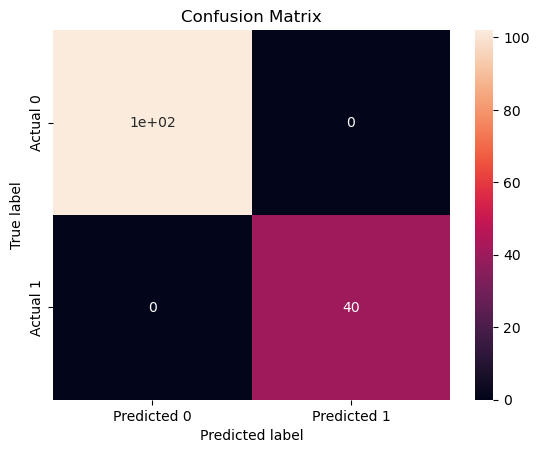

In [241]:
X=recordClass.drop(['Typical Home Value'],axis=1)
y=recordClass['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model=tree.DecisionTreeClassifier()
model=model.fit(X_train,y_train)
y_pred_train=model.predict(X_train)
print(classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
sns.heatmap(cm_df, annot=True,)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Obviously this model perfectly predicted the data it was trained on, lets check the test now.

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        43
           1       0.74      0.74      0.74        19

    accuracy                           0.84        62
   macro avg       0.81      0.81      0.81        62
weighted avg       0.84      0.84      0.84        62



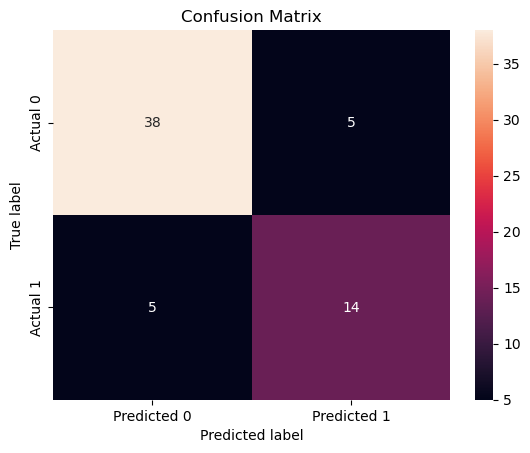

In [242]:
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
sns.heatmap(cm_df, annot=True,)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

This performed fairly well, most likely overfit though. We will tune the model later.

In [156]:
def plot_tree(model):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(model, 
                    filled=True)
    plt.show()

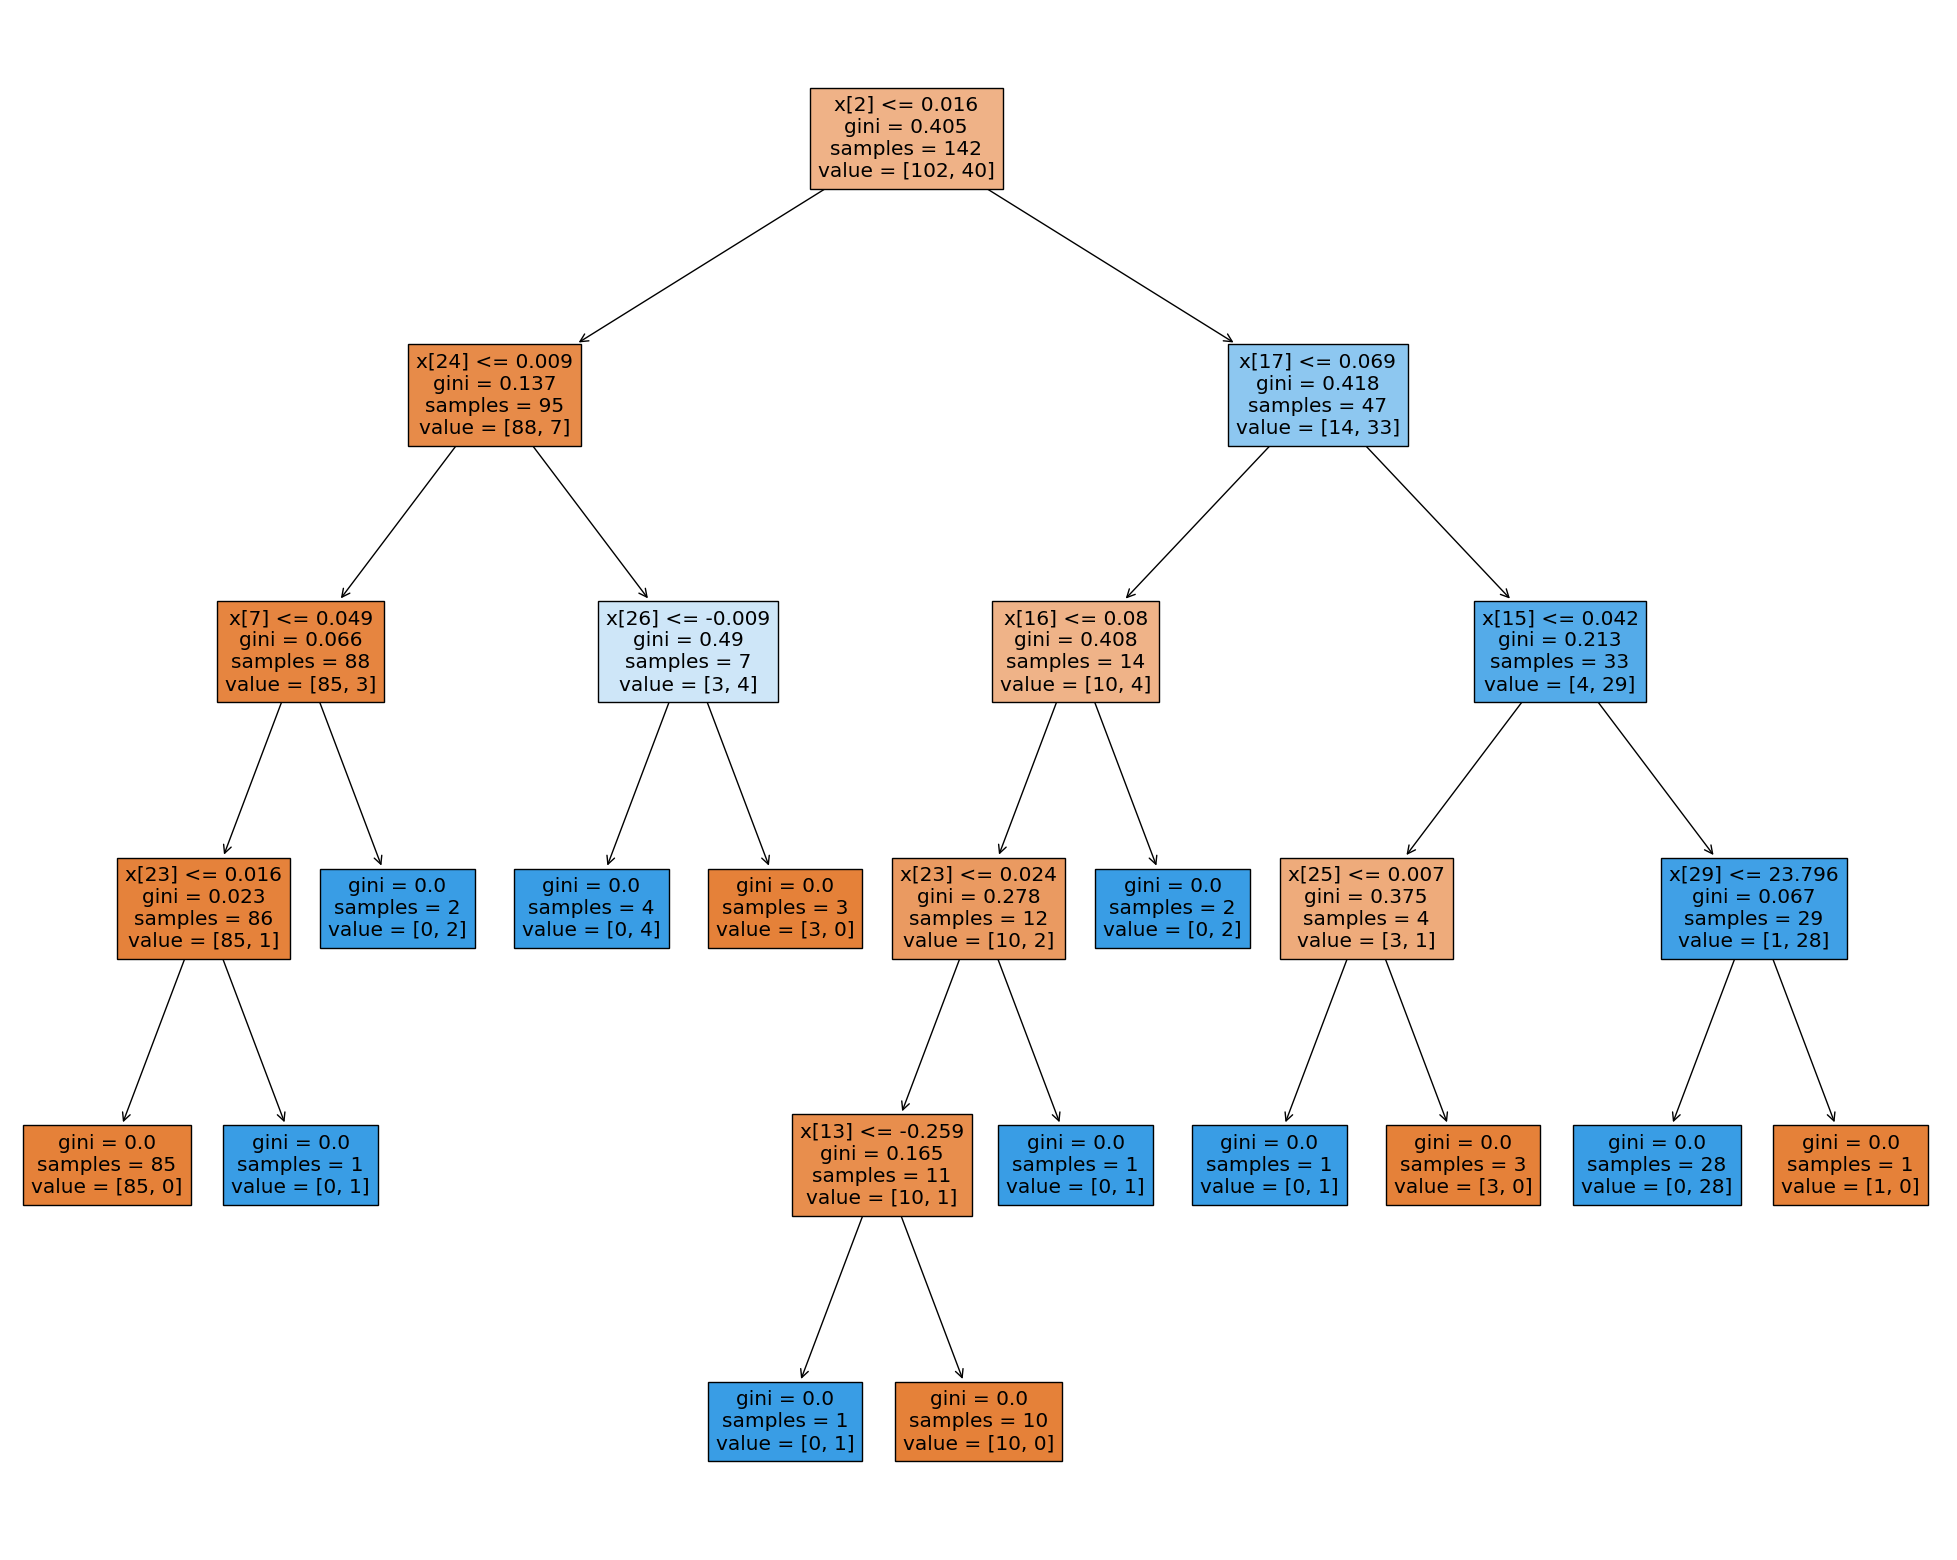

In [157]:
plot_tree(model)

Once I rename the variables this visual will easier to interpret.

Now lets run the regression.

In [265]:
X=record.drop(['Typical Home Value'],axis=1)
y=record['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=4)
regr_3 = DecisionTreeRegressor(max_depth=50)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)
regr_3.fit(X_train, y_train)
print("MODEL-1: Training, test MSE:",mean_squared_error(y_train, regr_1.predict(X_train)),mean_squared_error(y_test, regr_1.predict(X_test)))
print("MODEL-2: Training, test MSE:",mean_squared_error(y_train, regr_2.predict(X_train)),mean_squared_error(y_test, regr_2.predict(X_test)))
print("MODEL-3: Training, test MSE:",mean_squared_error(y_train, regr_3.predict(X_train)),mean_squared_error(y_test, regr_3.predict(X_test)))

MODEL-1: Training, test MSE: 0.0031465562469082313 0.008522672475205358
MODEL-2: Training, test MSE: 0.0010368920203482712 0.005067322999766866
MODEL-3: Training, test MSE: 0.0 0.007006317726230445


The max depth of four seems to perform the best. Again, we can tune the depth later in our analysis. This performed better than the dummy regressor.

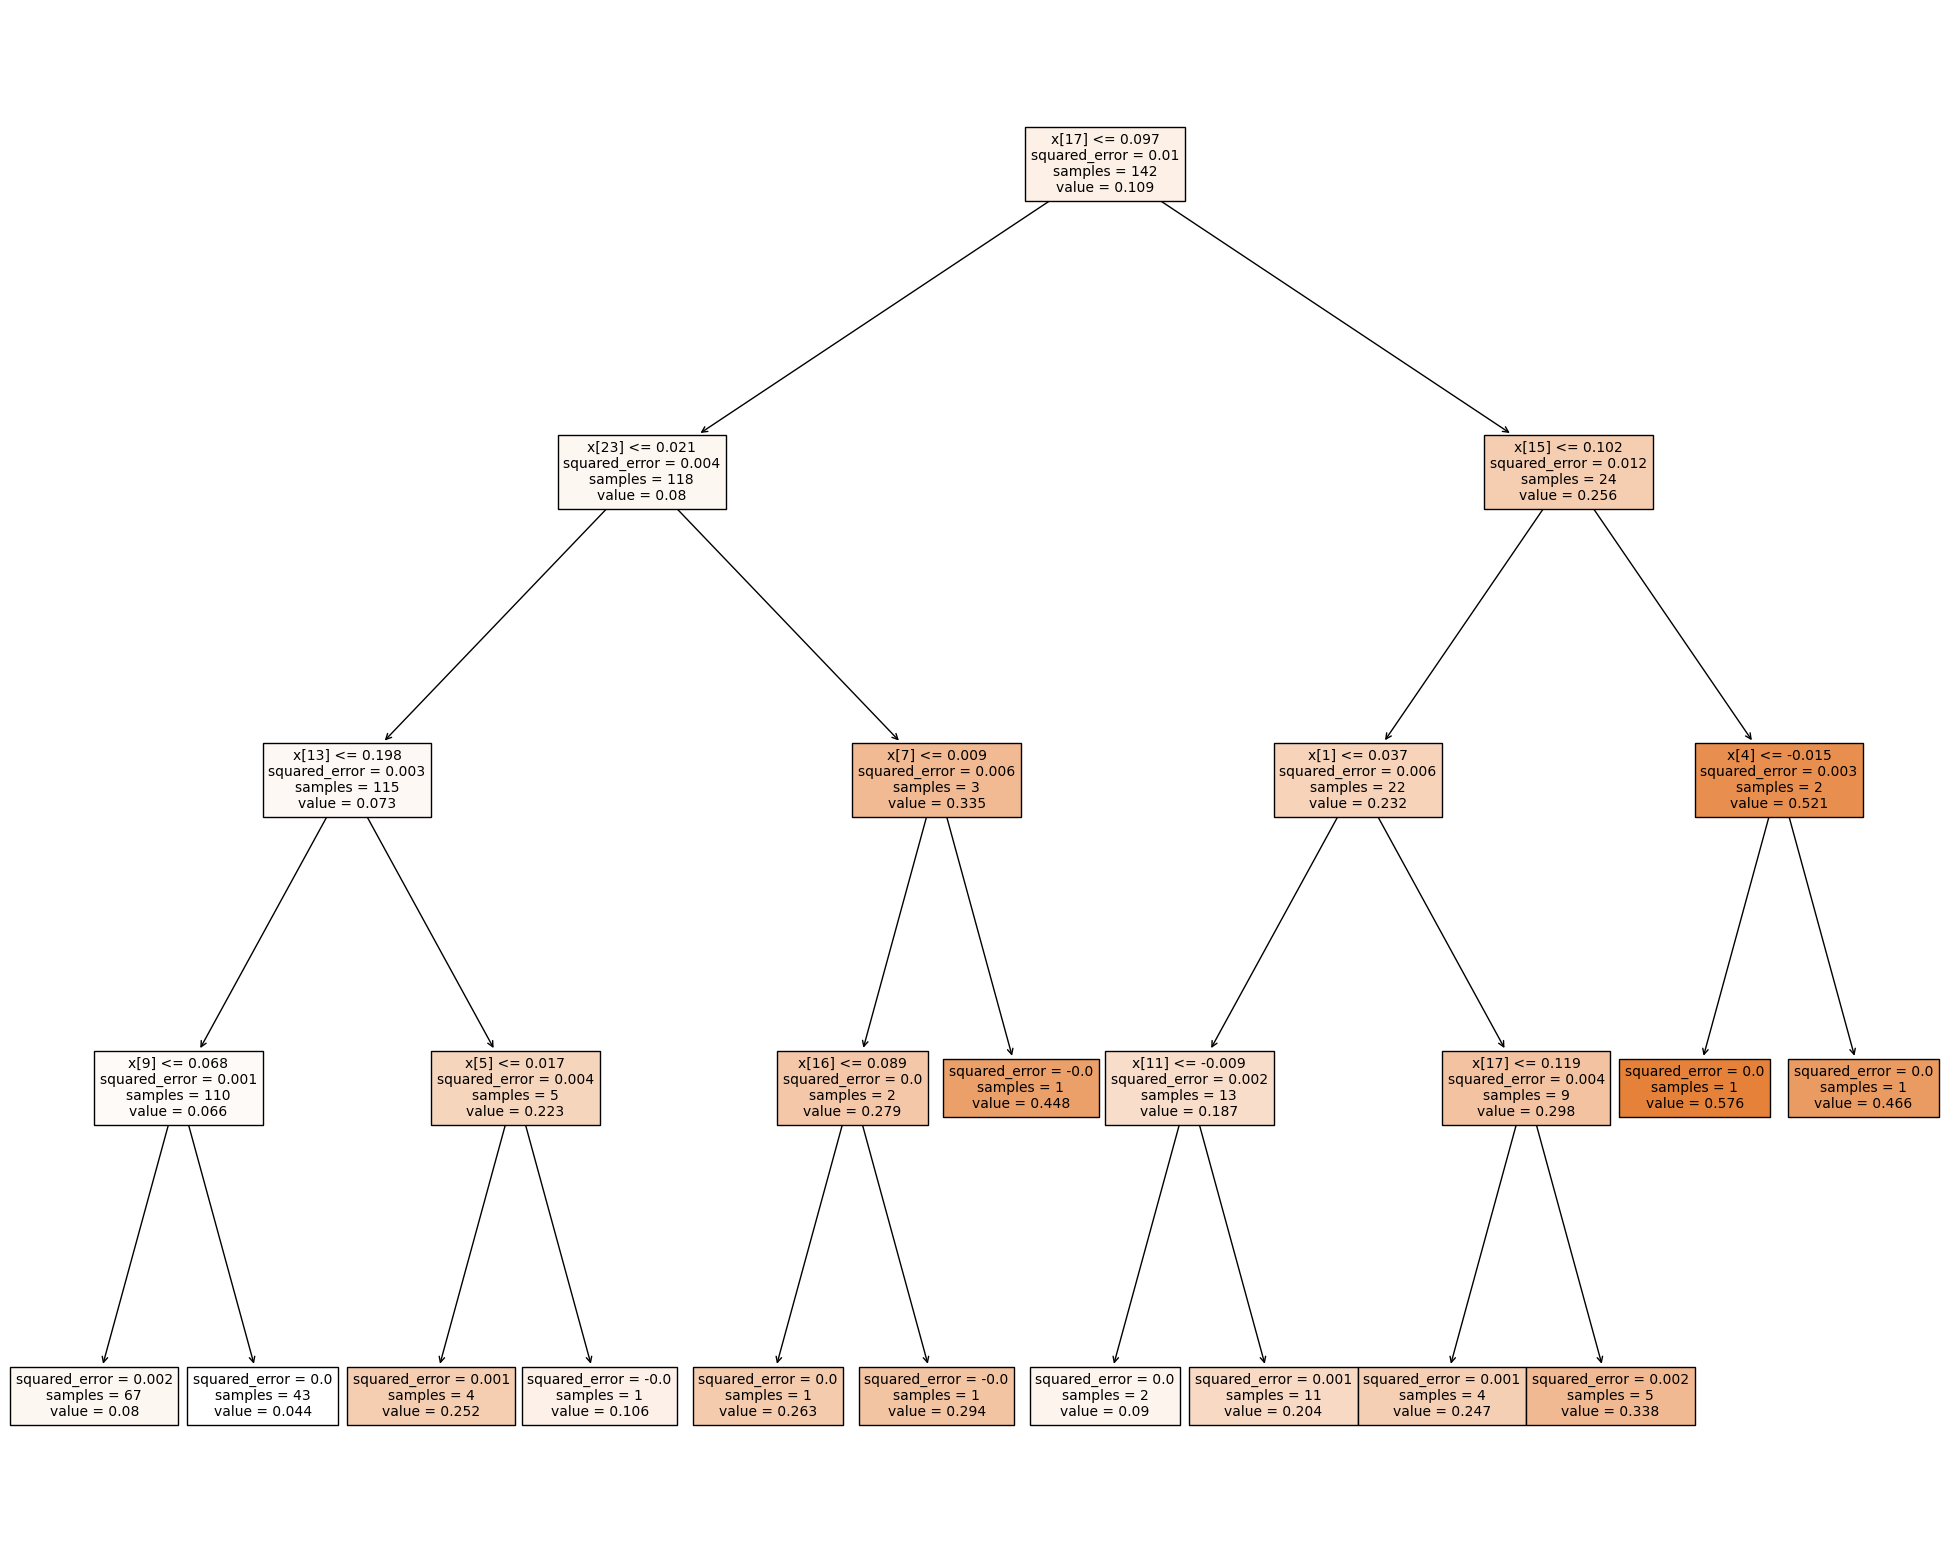

In [163]:
plot_tree(regr_2)

# Random Forest

Now I will use a random forest model to see how well it does above the decision tree baseline.

We will start with the classification task.

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        43
           1       1.00      0.84      0.91        19

    accuracy                           0.95        62
   macro avg       0.97      0.92      0.94        62
weighted avg       0.95      0.95      0.95        62



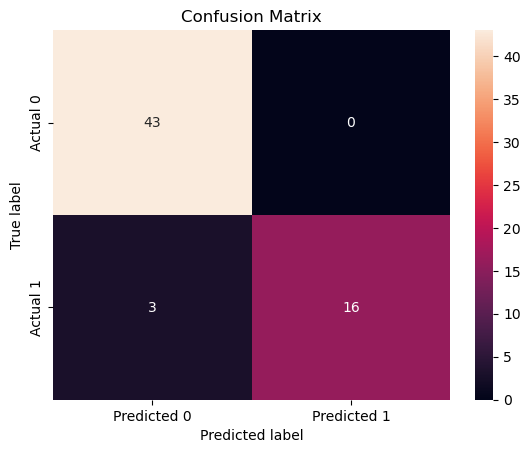

In [240]:
X=recordClass.drop(['Typical Home Value'],axis=1)
y=recordClass['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model=RandomForestClassifier()
model=model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
sns.heatmap(cm_df, annot=True,)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

This is a pretty good model and classifies well.

Now lets create a regression random forest model.

In [247]:
X=record.drop(['Typical Home Value'],axis=1)
y=record['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model=RandomForestRegressor()
model=model.fit(X_train,y_train)
print("MODEL: Training, test MSE:",mean_squared_error(y_train, regr_1.predict(X_train)),mean_squared_error(y_test, regr_1.predict(X_test)))

MODEL: Training, test MSE: 0.003146556246908231 0.008522672475205358


The normal decision tree actually performed better. We can investigate this more.

# Model Tuning

Now I will find the optimal paramaters for both the decision trees and randm forests

In [188]:
X=recordClass.drop(['Typical Home Value'],axis=1)
y=recordClass['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [193]:
test_results=[]
train_results=[]
for num_layer in range(1,20):
    model=tree.DecisionTreeClassifier(max_depth=num_layer)
    model=model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    test_results.append([num_layer,accuracy_score(y_test,y_pred),recall_score(y_test,y_pred,pos_label=0),recall_score(y_test,y_pred,pos_label=1)])
    train_results.append([num_layer,accuracy_score(y_train,y_pred_train),recall_score(y_train,y_pred_train,pos_label=0),recall_score(y_train,y_pred_train,pos_label=1)])
    

In [194]:
test_results=np.array(test_results)
train_results=np.array(train_results)

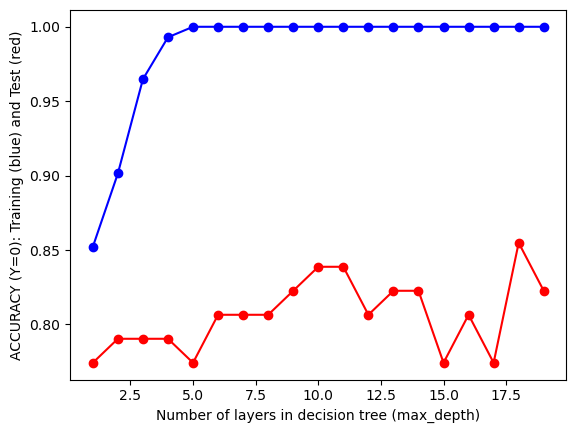

In [195]:
col=1
plt.plot(test_results[:, 0], test_results[:, col], '-or')
plt.plot(train_results[:, 0], train_results[:, col], '-ob')
plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('ACCURACY (Y=0): Training (blue) and Test (red)')
plt.show()

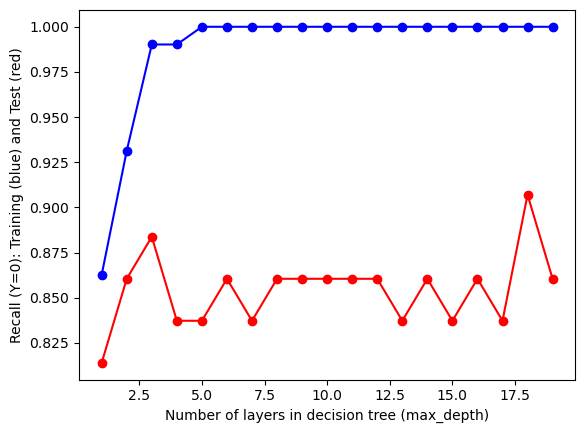

In [196]:
col=2
plt.plot(test_results[:, 0], test_results[:, col], '-or')
plt.plot(train_results[:, 0], train_results[:, col], '-ob')
plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('Recall (Y=0): Training (blue) and Test (red)')
plt.show()

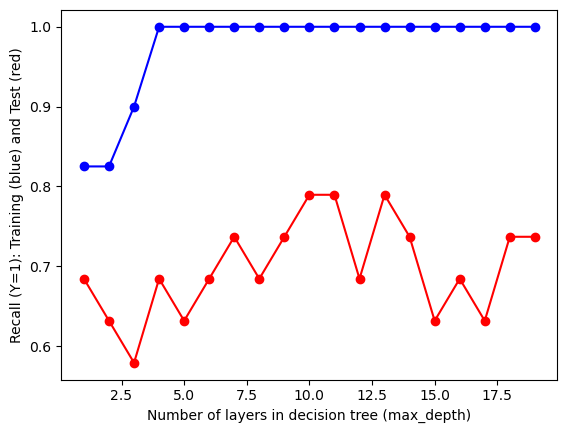

In [197]:
col=3
plt.plot(test_results[:, 0], test_results[:, col], '-or')
plt.plot(train_results[:, 0], train_results[:, col], '-ob')
plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('Recall (Y=1): Training (blue) and Test (red)')
plt.show()

Looks like optimal max_depth is 3.

In [198]:
X=record.drop(['Typical Home Value'],axis=1)
y=record['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
r_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=4)
regr_3 = DecisionTreeRegressor(max_depth=50)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)
regr_3.fit(X_train, y_train)
print("MODEL-1: Training, test MSE:",mean_squared_error(y_train, regr_1.predict(X_train)),mean_squared_error(y_test, regr_1.predict(X_test)))
print("MODEL-2: Training, test MSE:",mean_squared_error(y_train, regr_2.predict(X_train)),mean_squared_error(y_test, regr_2.predict(X_test)))
print("MODEL-3: Training, test MSE:",mean_squared_error(y_train, regr_3.predict(X_train)),mean_squared_error(y_test, regr_3.predict(X_test)))

In [ ]:
test_results=[]
train_results=[]
for num_layer in range(1,20):
    model=tree.DecisionTreeRegressor(max_depth=num_layer)
    model=model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    test_results.append([num_layer,accuracy_score(y_test,y_pred),recall_score(y_test,y_pred,pos_label=0),recall_score(y_test,y_pred,pos_label=1)])
    train_results.append([num_layer,accuracy_score(y_train,y_pred_train),recall_score(y_train,y_pred_train,pos_label=0),recall_score(y_train,y_pred_train,pos_label=1)])
    

In [199]:
test_results=np.array(test_results)
train_results=np.array(train_results)

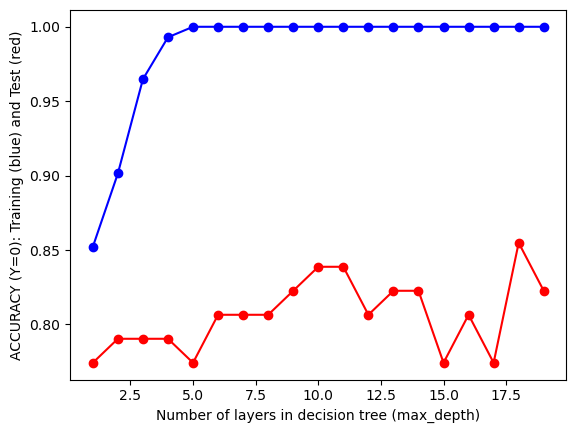

In [200]:
col=1
plt.plot(test_results[:, 0], test_results[:, col], '-or')
plt.plot(train_results[:, 0], train_results[:, col], '-ob')
plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('ACCURACY (Y=0): Training (blue) and Test (red)')
plt.show()

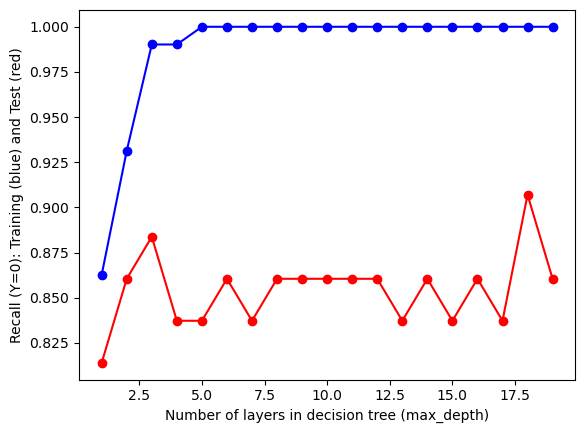

In [201]:
col=2
plt.plot(test_results[:, 0], test_results[:, col], '-or')
plt.plot(train_results[:, 0], train_results[:, col], '-ob')
plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('Recall (Y=0): Training (blue) and Test (red)')
plt.show()

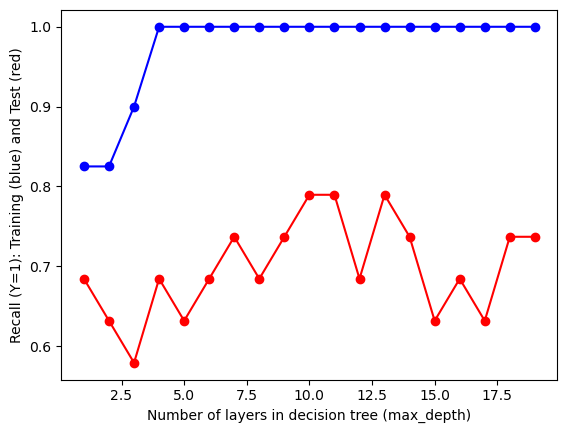

In [202]:
col=3
plt.plot(test_results[:, 0], test_results[:, col], '-or')
plt.plot(train_results[:, 0], train_results[:, col], '-ob')
plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('Recall (Y=1): Training (blue) and Test (red)')
plt.show()

Looks like 3 or 4.

Now on to the random forests.

In [230]:
X=recordClass.drop(['Typical Home Value'],axis=1)
y=recordClass['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model=RandomForestClassifier()

In [231]:
param = {'n_estimators': randint(50,500),'max_depth': randint(1,20)}
search = RandomizedSearchCV(model, param_distributions = param, n_iter=5, cv=5)

In [232]:
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F535775F10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F532392390>})

In [233]:
bestParams = search.best_params_
print(f'Best Hyperparameters: {bestParams}')

Best Hyperparameters: {'max_depth': 13, 'n_estimators': 419}


For the classification random forest model has the optimal performance with max_depth=6 and number of estimators=386.

In [234]:
X=record.drop(['Typical Home Value'],axis=1)
y=record['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model=RandomForestRegressor()

In [235]:
param = {'n_estimators': randint(50,500),'max_depth': randint(1,20)}
search = RandomizedSearchCV(model, param_distributions = param, n_iter=5, cv=5)

In [236]:
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F532694AD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F532695050>})

In [237]:
bestParams = search.best_params_
print(f'Best Hyperparameters: {bestParams}')

Best Hyperparameters: {'max_depth': 15, 'n_estimators': 412}


For the classification random forest model has the optimal performance with max_depth=15 and number of estimators=412.

# Final Results

Now lets train the models with our tuned hyper parameters and see their performance.

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        43
           1       0.59      0.53      0.56        19

    accuracy                           0.74        62
   macro avg       0.69      0.68      0.69        62
weighted avg       0.74      0.74      0.74        62



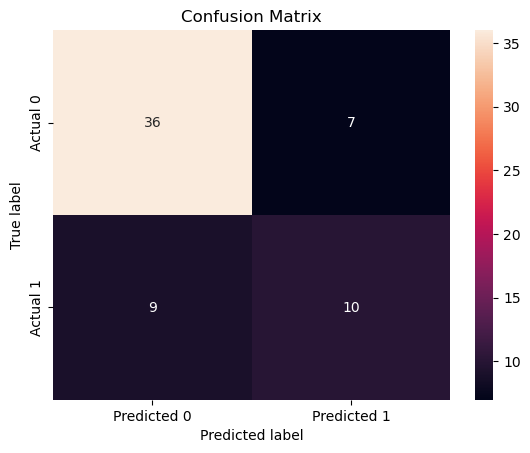

In [246]:
X=recordClass.drop(['Typical Home Value'],axis=1)
y=recordClass['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model=tree.DecisionTreeClassifier(max_depth=3)
model=model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
sns.heatmap(cm_df, annot=True,)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Changing the depth here doesnt change much.

In [274]:
X=record.drop(['Typical Home Value'],axis=1)
y=record['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model = DecisionTreeRegressor(max_depth=4)
model.fit(X_train, y_train)
print("MODEL: Training, test MSE:",mean_squared_error(y_train, model.predict(X_train)),mean_squared_error(y_test, regr_1.predict(X_test)))

MODEL: Training, test MSE: 0.0010368920203482712 0.008522672475205358


              precision    recall  f1-score   support

           0       0.93      1.00      0.97        43
           1       1.00      0.84      0.91        19

    accuracy                           0.95        62
   macro avg       0.97      0.92      0.94        62
weighted avg       0.95      0.95      0.95        62



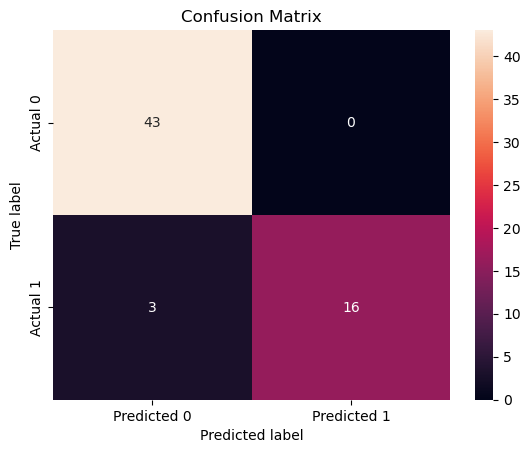

In [273]:
X=recordClass.drop(['Typical Home Value'],axis=1)
y=recordClass['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model=RandomForestClassifier(max_depth= 13,n_estimators=419)
model=model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
sns.heatmap(cm_df, annot=True,)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [275]:
X=record.drop(['Typical Home Value'],axis=1)
y=record['Typical Home Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
model=RandomForestRegressor(max_depth=15,n_estimators=412)
model=model.fit(X_train,y_train)
print("MODEL: Training, test MSE:",mean_squared_error(y_train, regr_1.predict(X_train)),mean_squared_error(y_test, regr_1.predict(X_test)))

MODEL: Training, test MSE: 0.0031465562469082313 0.008522672475205358


My final models did a fairly good job with predicting the percent increase in home value in states. With a random forest, the classification model only misclassfied three data points.My regression models still need some more work. The decision tree actually performed better than the random forest with the lowest mean squared error being .0059, this is compared to the baseline of .009. We posssibly could improve the regression decision tree and random forests be reducing the number of features as I suspect that is an issue. 

# Conclusion

I discovered that we can accuratly predict what states will have a signficant percent change from year to year based on census data. This is promising results, as we can see what states to buy property in just looking at census data that comes out every year. With the regression task, we tried to predict an actual number that represented the percent increase of home values after plugging in the census data percent change. With a mean squared error of only .0059, this model shows promise of being useful for its purpose.

Missing the 2020 year in my data was detrimental for my analysis as the percent change from 2019-2021 is higher than other years because it is a longer time period. Also, some of the margin of errors for my census data was fairly high, so not all the data may be accurate. In the future, I want to focus on smaller geographic regions and explore other geography hierarchies, as a state is a large area. 